# Media Analyser - By Gabriel Hanich

In [38]:
# Imports
import json
from collections import Counter
import matplotlib.pyplot as plt
from datetime import date, datetime
import datetime as dt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as corupusStopwords
from nltk.util import pr

from wordcloud import WordCloud, STOPWORDS

import praw

import sys
sys.path.append('../') # Allows importing of local modules

from lib.data import getData
from lib.media import outlet, article

In [39]:
%matplotlib widget

In [40]:
# Constants
dataVersion = 2
stopwords = corupusStopwords.words("english")

In [41]:
def daterange(date1, date2): # Returns list of dates between 2 dates
    for n in range(int((date2 - date1).days)+1):
        yield date1 + dt.timedelta(n)

In [42]:
with open("../media Outlets.csv") as outletsFile: # Get list of outlets
    outletsData = getData(outletsFile)

outlets = []
for thisOutlet in outletsData:
    outlets.append(outlet(thisOutlet[0]))

    with open("../data/" + str(dataVersion) + "/json/" + thisOutlet[0] + ".json", encoding="utf-8") as dataFile:
        outlets[-1].setDayDict(json.load(dataFile)) # Write daydict to outlet Object

In [43]:
def getXYVals(thisOutlet, statType, startDate, endDate, titleSearchWords, commonWordCount):
    # Returns a list containing the x, y and z (annotation) for a given media outlet
    xVals = []
    yVals = []
    zVals = []
    for myDate in list(daterange(startDate, endDate)): # For every date between the given start and end date
        try:
            articleCount = 0
            avgSentiment = 0
            commonWords = []
            totalWords = []
            for articleIndex, article in enumerate(thisOutlet.dayDict[myDate.strftime("%d/%m/%Y")]):
                # If there are no title search words OR title contains wanted word
                if titleSearchWords == [] or set(titleSearchWords).intersection(word_tokenize(article["headline"].lower())):
                    articleCount += 1
                    avgSentiment += article["intensityScore"]
                    for word in word_tokenize(article["headline"]):
                        if len(word) > 2:
                            if word.lower() not in stopwords:
                                totalWords.append(str(word))

            commonWordsRaw = Counter(totalWords).most_common(commonWordCount)
            commonWords = []
            for word in commonWordsRaw:
                commonWords.append(list(word))
            # Append data depending on chosen chart type        
            if statType == "articleCount":
                yVals.append(articleCount)
            elif statType == "avgSentiment":
                try:
                    yVals.append(avgSentiment / articleCount)
                except ZeroDivisionError:
                    yVals.append(0)
            elif statType  == "commonWords":
                yVals.append(articleCount)
                zVals.append(commonWords)

            xVals.append(myDate)
        except KeyError: # In case outlet has no articles published on that date (Returns empty lists)
            pass
    return xVals, yVals, zVals

In [86]:
# User settings
startingDate = "13/9/2021"
endDate = "23/01/2022"

doSetDates = True # Whether to use user-specified dates
doSetOutlets = False # Whether to limit search to a set of outlets
commonWordCount = 1 # How many common words per day are displayed
doTotalOutlets = False # Whether to take the outlets as a total
titleSearchWords = [["covid"], ["morrison", "liberal"], ["labour"]] # Only include articles with headlines containing these words (Leave BLANK to disable)
doSimilarWords = True # Whether to scan reddit for similar words to the title search words
searchPostsCount = 100 # How many posts to scan per word
searchWords = 5 # How many words from reddit are added per keyword
setOutlets = ["The Guardian"] # Only include a set of outlets
chartType = "avgSentiment" # Type of chart to make'


In [87]:
startingDate = datetime.strptime(startingDate, "%d/%m/%Y")
endDate = datetime.strptime(endDate, "%d/%m/%Y")

In [88]:
# Do Total outlets
if doTotalOutlets:
    totalOutlet = outlet("Total")
    thisDayDict = {}
    for date in daterange(startingDate, endDate):
        strDate = datetime.strftime(date, "%d/%m/%Y")
        thisArticleList = []
        for mediaOutlet in outlets:
            try:
                for articleIndex, article in enumerate(mediaOutlet.dayDict[strDate]):
                    thisArticleList.append(article)
            except KeyError:
                pass
        if len(thisArticleList) != 0:
            thisDayDict[strDate] = thisArticleList
    totalOutlet.setDayDict(thisDayDict)

In [89]:
if doSimilarWords:
    newTitleWords = []
    # ADD REDDIT INIT HERE
    all = reddit.subreddit("all") # Create subreddit object
    for section in titleSearchWords:
        sectionKeyWords = []
        # Flatten section into single list containing all the words
        wordsList = []
        if type(section) == list: # If list contains sub-lists (i.e has multiple search words per section)
            for word in section:
                wordsList.append(word)
        else:
            wordsList.append(section)
        print(wordsList)
        foundWords = []
        for searchWord in wordsList:
            for post in all.search(searchWord, limit=searchPostsCount): # Search for the top (seachCount) posts about (searchWord)
                title = word_tokenize(post.title)
                for word in title:
                    word = word.lower()
                    if not word in stopwords and len(word) > 2:
                        foundWords.append(word)
        for keyWord in Counter(foundWords).most_common(searchWords):
            sectionKeyWords.append(keyWord[0])
        newTitleWords.append(sectionKeyWords)
                    
        

['covid']
['morrison', 'liberal']
['labour']


In [96]:
titleSearchWords = newTitleWords

In [97]:
print(titleSearchWords)

[['covid', 'covid-19', 'positive', 'vaccine', 'vaccinated'], ['morrison', 'scott', 'liberals', 'liberal', 'temuera'], ['labour', 'party', 'corbyn', 'tory', 'starmer']]


In [98]:
if doSetOutlets:
    # Trim down outlet list to only include those chosen
    newOutlets = []
    for mediaOutlet in outlets:
        if mediaOutlet.name in setOutlets:
            newOutlets.append(mediaOutlet)
    setOutlets = newOutlets


In [99]:
if doTotalOutlets:
    plotOutlets = [totalOutlet]
elif doSetOutlets:
    plotOutlets = setOutlets
else:
    plotOutlets = outlets

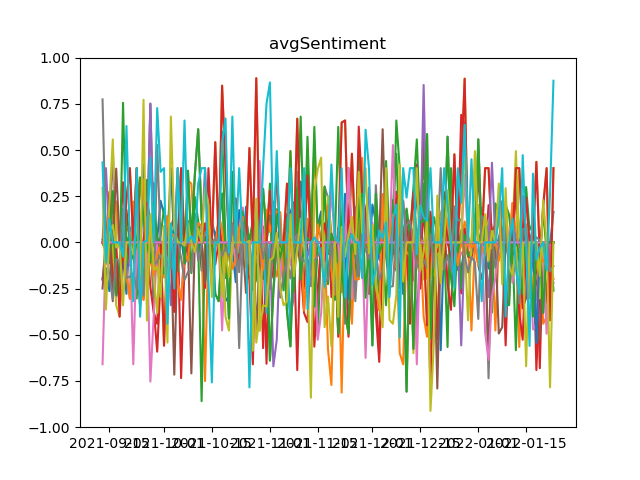

In [100]:
# Plot data 
fig, ax = plt.subplots(1)
ax.set_title(chartType)

for mediaOutlet in plotOutlets:
    try:
        if not doSetDates:
            startingDate = list(mediaOutlet.dayDict.keys())[0] # Get date of first article
            endDate = list(mediaOutlet.dayDict.keys())[-1] # Get date of last article

            startingDate = datetime.strptime(startingDate, "%d/%m/%Y")
            endDate = datetime.strptime(endDate, "%d/%m/%Y")

    except IndexError:
        continue
    
    doMultiCategories = False
    if len(titleSearchWords) != 0:
        if type(titleSearchWords[0]) == list:
            doMultiCategories = True
            for searchList in titleSearchWords:
                xVals, yVals, zVals = getXYVals(mediaOutlet, chartType, startingDate, endDate, searchList, commonWordCount)


                ax.plot(xVals, yVals, label=mediaOutlet.name + " " + str(searchList))  

                if len(zVals) != 0: # If there are annotations present
                    for dayIndex, dayPoint in enumerate(zVals):
                        for i in range(len(dayPoint)):
                            ax.annotate(dayPoint[i][0], (xVals[dayIndex], yVals[dayIndex] - i))
    if not doMultiCategories:
        xVals, yVals, zVals = getXYVals(mediaOutlet, chartType, startingDate, endDate, titleSearchWords, commonWordCount)
        mediaOutlet.setVals(xVals, yVals, zVals)
        ax.plot(xVals, yVals, label=mediaOutlet.name)  
        
        if len(zVals) != 0: # If there are annotations present
            for dayIndex, dayPoint in enumerate(zVals):
                for i in range(len(dayPoint)):
                    ax.annotate(dayPoint[i][0], (xVals[dayIndex], yVals[dayIndex] - i))
                
        
if chartType == "avgSentiment":
    plt.ylim(-1, 1)

In [13]:
# Text outputs
for mediaOutlet in plotOutlets:
    print(mediaOutlet.name)
    if chartType == "articleCount" or chartType == "commonWords":
        articleCount = 0
        for val in mediaOutlet.yVals:
            articleCount += val
        print("Published " + str(articleCount) + " articles in " + str(len(mediaOutlet.xVals)) + " days")
        try:
            print("An average of " + str(round(articleCount / len(mediaOutlet.xVals), 2)) + " articles per day")
        except ZeroDivisionError:
            print("An average of 0 articles per day")
    elif chartType == "avgSentiment":
        largestScore, smallestScore, totalScore = -1, 1, 0
        largestIndex, smallestIndex = 0, 0
        for valIndex, val in enumerate(mediaOutlet.yVals):
            val = round(val, 2)
            totalScore += val
            if val < smallestScore:
                smallestScore = val
                smallestIndex = valIndex
            if val > largestScore:
                largestScore = val
                largestIndex = valIndex
        try:
            print("Had an average daily sentiment of " + 
                  str(round(totalScore / len(mediaOutlet.xVals), 2)) + " over " + 
                  str(len(mediaOutlet.xVals)) + " days") 
        except ZeroDivisionError:
            print("Had an average daily sentiment of 0")
            
        try:
            print("Most POSITIVE day was " + 
                  datetime.strftime(mediaOutlet.xVals[largestIndex], "%d/%m/%Y") + 
                  " scoring " + str(largestScore))
            print("Most NEGATIVE day was " + 
                  datetime.strftime(mediaOutlet.xVals[smallestIndex], "%d/%m/%Y") + 
                  " scoring " + str(smallestScore))
        except IndexError:
            print("NO DATA FOR MOST POSITIVE OR NEGATIVE DAYS")
    print("\n")

ABC News
Had an average daily sentiment of -0.09 over 133 days
Most POSITIVE day was 09/10/2021 scoring 0.12
Most NEGATIVE day was 18/01/2022 scoring -0.24


9 News
Had an average daily sentiment of -0.13 over 133 days
Most POSITIVE day was 03/11/2021 scoring 0.11
Most NEGATIVE day was 23/11/2021 scoring -0.39


Syndey Morning Herald
Had an average daily sentiment of -0.0 over 132 days
Most POSITIVE day was 31/10/2021 scoring 0.12
Most NEGATIVE day was 20/01/2022 scoring -0.11


The Australian
Had an average daily sentiment of 0
NO DATA FOR MOST POSITIVE OR NEGATIVE DAYS


SBS Australia
Had an average daily sentiment of -0.1 over 133 days
Most POSITIVE day was 10/10/2021 scoring 0.27
Most NEGATIVE day was 24/11/2021 scoring -0.39


Independent Australia
Had an average daily sentiment of -0.1 over 133 days
Most POSITIVE day was 27/12/2021 scoring 0.68
Most NEGATIVE day was 27/09/2021 scoring -0.72


Daily Telegraph
Had an average daily sentiment of -0.07 over 132 days
Most POSITIVE day 

ABC News WORD PLOT


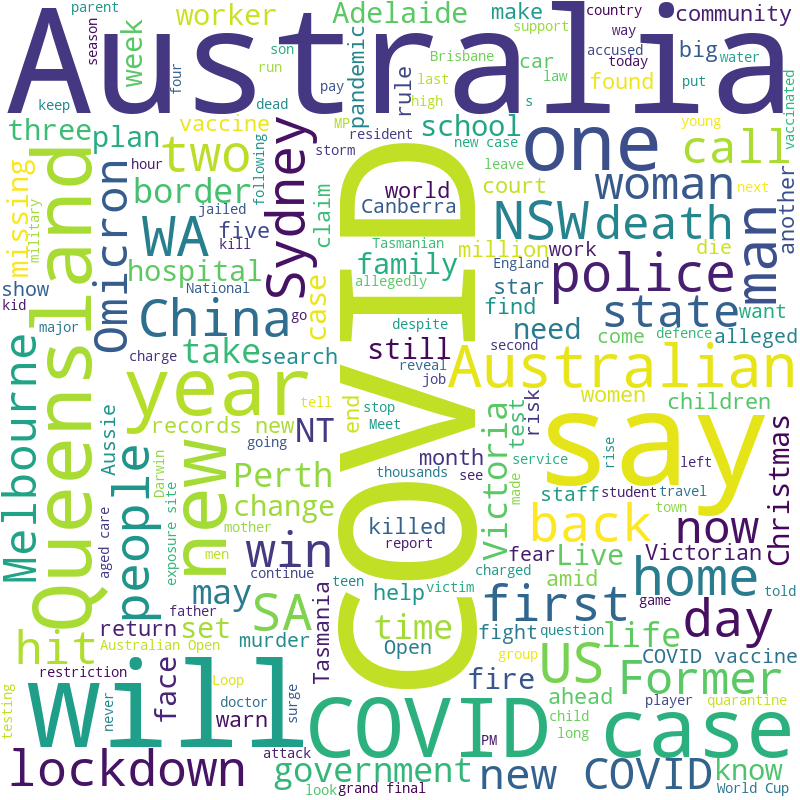

In [14]:
# Create word cloud
stopwords = set(STOPWORDS)

mediaOutlet = plotOutlets[0]
articleString = ""
for thisDate in daterange(startingDate, endDate):
    strDate = thisDate.strftime("%d/%m/%Y")
    try:
        for article in mediaOutlet.dayDict[strDate]:
            articleString += article["headline"] + " "
    except KeyError:
        pass
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(articleString)

print(mediaOutlet.name + " WORD PLOT")

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title(mediaOutlet.name)
plt.show()


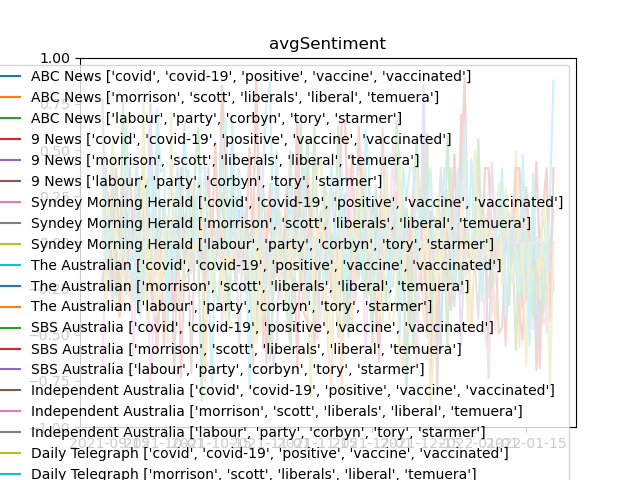

In [101]:
ax.legend()
plt.show()